In [1]:
#!pip install Pypdf2

In [2]:
import datetime 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib as mpl
import warnings

from PyPDF2 import PdfMerger

In [3]:
def get_duration_timedelta(string_time=None, time_format="%H:%M:%S"):
    strptime = datetime.datetime.strptime(string_time,time_format).time()
    timedelta = datetime.timedelta(
        hours=strptime.hour,
        minutes=strptime.minute,
        seconds=strptime.second,
        microseconds=strptime.microsecond,
    )
    return timedelta

def get_account_time(df):
    account_time = datetime.datetime.now() - df.start_time.min()
    years = account_time.total_seconds()/(3600*24*365)
    return years

def percentage_of_profile_views_overtime(df):
    df['percentage'] = df._count/df._count.sum()
    return df

def merge_different_individual_start(df):
    df['start_time_list'] = [df.start_time.to_list()]*len(df)
    df['end_time_list'] =  [df.end_time.to_list()]*len(df)
    df['bookmark_list'] =  [df.bookmark.to_list()]*len(df)
    df['total_duration_seen'] = df.duration.sum()/60
    drop_columns = [
        'start_time',
        'end_time',
        'duration',
        'bookmark',
        'latest_bookmark',
    ]
    return df.drop(drop_columns, axis=1)

def get_series_info(df, plot=False, save=0):
    total_duration = df.duration.sum()/3600
    total_lapsed_time = (df.end_time.max() - df.start_time.min()).total_seconds()/3600
    speed = total_duration/total_lapsed_time
    chapters = df.title.nunique()
    chapter_speed = chapters/total_lapsed_time
    mean_duration = total_duration/df.title.nunique()

    waiting_time_series = pd.Series(df.start_time.iloc[:-1].to_numpy() - df.end_time.iloc[1:].to_numpy())
    waiting_time = waiting_time_series.apply(lambda x: x.total_seconds()/3600)
    waiting_time_mean = waiting_time.mean()
    waiting_time_median = waiting_time.median()
    waiting_time_std = waiting_time.std()
    waiting_time_max = waiting_time.max()
    waiting_time_min = waiting_time.min()
    
    df['hour'] = df.start_time.apply(lambda x : x.hour + x.minute/60)
    if plot:
        plt.figure(figsize=(13,4))
        plt.scatter(df.start_time, df.hour, color='r')
        plt.plot(df.start_time, df.hour, linestyle='--', alpha=0.5, color='k')
        plt.ylabel('Hora del día')
        plt.xlabel('Fecha')
        plt.title(df.new_title.unique()[0])
        plt.yticks([0, 4, 8, 12, 16, 20, 24])
        plt.ylim(-0.5,24.5)
        if save:
            plt.savefig(f'{images_data_path}img5_netflix_serie{save-1}.pdf')  
        plt.close()
        
    results = {
        'total_duration_hours': total_duration,
        'total_lapsed_hours': total_lapsed_time,
        'effective_seen_time':speed,
        'different_chapters_seen': chapters,
        'effective_seen_time_in_different_chapters': chapters * speed,
        'chapter_speed': chapter_speed, 
        'waiting_time_mean': waiting_time_mean,
        'waiting_time_median': waiting_time_median,
        'waiting_time_std': waiting_time_std,
        'waiting_time_max': waiting_time_max,
        'waiting_time_min': waiting_time_min,
    }

    return pd.Series(results)

In [4]:
warnings.filterwarnings("ignore")
plt.style.use('bmh')
#print(list(mpl.colormaps.keys())) # List of available colormaps
colormap = mpl.colormaps['Reds'].resampled(100)

In [5]:
general_path = os.path.join(os.getcwd(), '..')
raw_data_path = os.path.join(general_path, 'data/raw')
raw_folder = os.path.join(raw_data_path, 'netflix-report')
interest_data_path = os.path.join(raw_folder, 'CONTENT_INTERACTION/ViewingActivity.csv')
netflix_data_all = pd.read_csv(interest_data_path)
report_path = os.path.join(general_path, 'reports/')
images_data_path = os.path.join(report_path, 'figures/')

In [6]:
# Use columns easier:
new_columns = {col:col.lower().strip().replace(' ', '_') for col in netflix_data_all.columns}
netflix_data_all.rename(columns=new_columns, inplace=True)

profiles_dict = {
    profile_name:f'profile_{num}'  
    for num, profile_name 
    in enumerate(netflix_data_all.profile_name.unique())
}
netflix_data_all.profile_name = netflix_data_all.profile_name.apply(
    lambda x: profiles_dict[x]
)

netflix_data_all.start_time = pd.to_datetime(netflix_data_all.start_time)

netflix_data_all.start_time = netflix_data_all.start_time - datetime.timedelta(hours=6)

netflix_data_all.duration = netflix_data_all.duration.apply(
    get_duration_timedelta
)

netflix_data_all['end_time'] = netflix_data_all.start_time + netflix_data_all.duration

netflix_data_all.duration = netflix_data_all.duration.apply(
    lambda x: x.total_seconds()
)
netflix_data_all['new_title'] = netflix_data_all.title.apply(lambda x: x.split(':')[0])

netflix_data_no_autoplayed = netflix_data_all[netflix_data_all.attributes.isna()]
netflix_data = netflix_data_no_autoplayed[netflix_data_no_autoplayed.supplemental_video_type.isna()]

netflix_data.drop(['attributes', 'supplemental_video_type'], axis=1, inplace=True)

In [7]:
netflix_data_all.groupby('profile_name').apply(get_account_time)

profile_name
profile_0    6.436281
profile_1    8.962216
profile_2    6.288218
profile_3    1.326395
profile_4    8.235755
dtype: float64

In [8]:
grouper_m = pd.Grouper(key='start_time', freq='M')
grouper_d = pd.Grouper(key='start_time', freq='D')
grouper_w = pd.Grouper(key='start_time', freq='W')

In [9]:
data_over_time = netflix_data.groupby([grouper_m, 'profile_name']).count().device_type.reset_index().rename(
    columns={'device_type': '_count'}
)
plt.figure(figsize=(13,8))
for profile in data_over_time.profile_name.unique():
    temporal = data_over_time[data_over_time.profile_name == profile]
    plt.plot(temporal.start_time, temporal._count, label=profile)
plt.legend()
plt.title('Conteo de diversas actividades vistas en netflix')
plt.ylabel('Conteo')
plt.xlabel('Fecha')
plt.savefig(f'{images_data_path}img0_conteo_por_perfil.pdf')  
plt.close()

In [10]:
pd.pivot_table(
    data_over_time.groupby('start_time').apply(percentage_of_profile_views_overtime),
    values='percentage',
    columns=['profile_name'],
    index='start_time',
    fill_value=0
).plot.area(stacked=True, linewidth=0.1, figsize=(13,8))
plt.title('Porcentaje de vistas de cada perfil de netflix a traves del tiempo')
plt.ylabel('Porcentaje')
plt.xlabel('Fecha')
plt.xlim('2012-06-01','2023-06-01')
plt.savefig(f'{images_data_path}img1_porcentaje_por_perfil.pdf')  
plt.close()

In [11]:
pd.pivot_table(
    data_over_time,
    values='_count',
    columns=['profile_name'],
    index='start_time',
    fill_value=0
).plot.area(stacked=True, linewidth=0.1, figsize=(13,8))
plt.title('Conteo de vistas de cada perfil de netflix a traves del tiempo')
plt.ylabel('Conteo total')
plt.xlabel('Fecha')
plt.xlim('2013-06-01','2023-01-01')
plt.savefig(f'{images_data_path}img2_conteo_por_perfil_stack.pdf')  
plt.close()

In [12]:
series_traits_list = [
    ": Season",
    ": Book",
    " \(Episode ",
    " : Episode ",
    " : Part ",
    " \(Chapter ",
    " : Chapter ",
    ": Temporada",
    ": Libro", 
    " \(Capítulo ",
    " : Capítulo ",
    " : Parte ",
    " : Episodio ",
    " \(Episodio ",
]

series_trait_df = netflix_data.title=='initialization of a false series'
for series_trait in series_traits_list:
    series_trait_df += netflix_data.title.str.contains(series_trait)
    
netflix_data.loc[series_trait_df, 'is_serie'] = True
netflix_data.loc[~series_trait_df, 'is_serie'] = False

In [13]:
df = netflix_data[netflix_data.profile_name == 'profile_0']
df.loc[df.is_serie == False, 'individual_start'] = df.title.map(
    df.title.value_counts()
)
movies = df[df.is_serie==False]

movies[movies.start_time > pd.to_datetime('2022-01-01')].groupby('title').apply(merge_different_individual_start).drop_duplicates('title').sort_values(
    'total_duration_seen', ascending=True).plot.barh(x='new_title', y='total_duration_seen', color='red')

plt.title('Películas más importantes')
plt.ylabel('Título')
plt.xlabel('Tiempo total de vista (minutos)')
plt.savefig(f'{images_data_path}img3_netflix_peliculas_importantes.pdf')  
plt.close()

In [14]:
series =  df[df.is_serie==True]
series_information = series.groupby('new_title').apply(get_series_info).sort_values(
    'total_duration_hours', ascending=False)
series_information = series_information[series_information.waiting_time_min.notna()].head(30)

series_information.sort_values('total_duration_hours', ascending=True).total_duration_hours.plot.barh(color='red')
plt.title('Series más importantes')
plt.ylabel('Título')
plt.xlabel('Tiempo total de vista (horas)')
plt.savefig(f'{images_data_path}img4_netflix_series_importantes.pdf')  
plt.close()

for num, title in enumerate(series_information.index):
    test = series[series.new_title==title]
    if test.shape[0]>1:
        get_series_info(test, plot=True, save=num+1)

Text(225.58333333333334, 0.5, 'Día numérico de la semana')

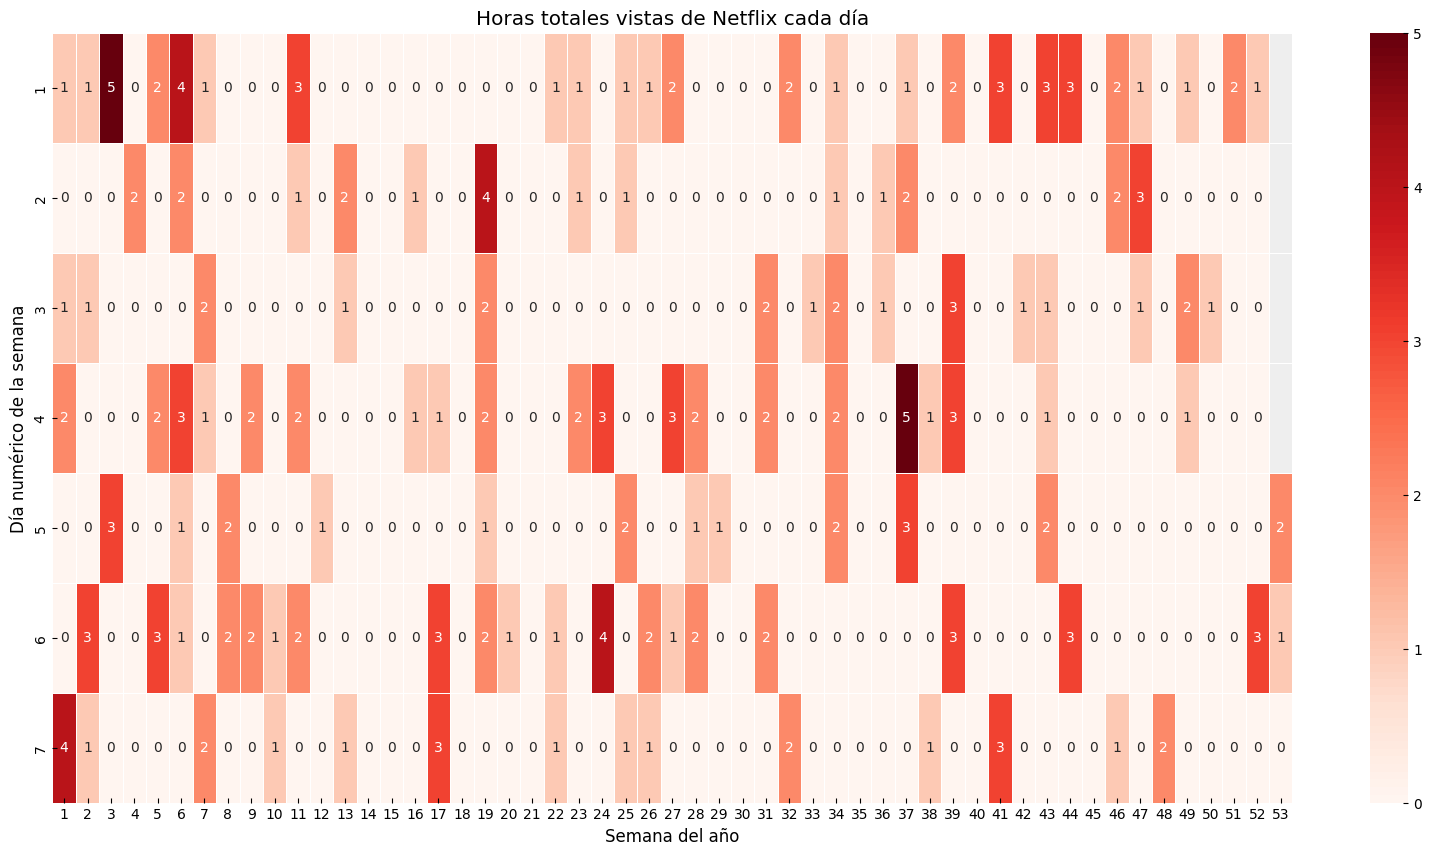

In [15]:
plt.figure(figsize=(20,10))
calendar = df[
    df.start_time.between(pd.to_datetime('2021-01-01'), pd.to_datetime('2022-01-03'))
    #df.start_time.between(pd.to_datetime('2022-01-01'), pd.to_datetime('2023-01-03'))

].groupby(grouper_d).duration.sum().reset_index()
calendar.duration = calendar.duration//3600
calendar['day_of_week'] = calendar.start_time.apply(lambda x: x.day_of_week+1)
calendar['week'] = calendar.start_time.apply(lambda x: x.week)
calendarized = pd.pivot_table(calendar, index='day_of_week', columns=['week'], values='duration')
sns.heatmap(
    calendarized,
    annot=True, linewidth=.5, cmap=colormap
)
plt.title('Horas totales vistas de Netflix cada día')
plt.xlabel('Semana del año')
plt.ylabel('Día numérico de la semana')
#plt.savefig(f'{images_data_path}img6_netflix_peliculas_importantes.pdf')  
#plt.close()

In [16]:
plt.figure(figsize=(20,10))
calendar_year = df.groupby(grouper_m).duration.sum().reset_index()
calendar_year.duration = calendar_year.duration//3600
calendar_year['month'] = calendar_year.start_time.apply(lambda x:x.month) #x.month_name())
calendar_year['year'] = calendar_year.start_time.apply(lambda x: x.year)
calendarized = pd.pivot_table(calendar_year, index='year', columns=['month'], values='duration')
sns.heatmap(
    calendarized,
    annot=True, linewidth=.5, cmap=colormap
)
plt.title('Horas totales vistas de Netflix cada mes')
plt.xlabel('Número de mes')
plt.ylabel('Año')
plt.savefig(f'{images_data_path}img6_netflix_horas_mes_anio.pdf')  
plt.close()

In [20]:
merger = PdfMerger()
for pdf_file in os.listdir(images_data_path):
    if pdf_file.endswith('.pdf'):
        merger.append(f'{images_data_path}{pdf_file}')

merger.write(f"{report_path}report.pdf")
merger.close()